# Publication plots : Plot data from simulation parametric sweeps


In [1]:
# Collate data from parametric sweeps for combined analysis plots
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pyfilaments.analysisutils as analysis
from tqdm import tqdm
import pandas as pd
import h5py

from joblib import Parallel, delayed
import multiprocessing
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 14})

# Create a folder for storing Publication figures

publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'


# Set the values for the publication figure parameters
rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 14})
sns.set(font_scale = 1)

dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', 're', 'enum', 

## Publication plots: Filament Shape Dynamics

In [12]:
# Load simulation file
# Period 2
file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-10-19/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 10
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point/SimResults_00.hdf5'


# Period 1
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.551282051282051_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 6
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/SimResults_00.hdf5'
# Aperiodic
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.6794871794871793_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 4
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/SimResults_00.hdf5'
filament = analysis.analysisTools(file = file)


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-10-19/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point
Data file SimResults_00.hdf5


Tip scatter density plot


<IPython.core.display.Javascript object>


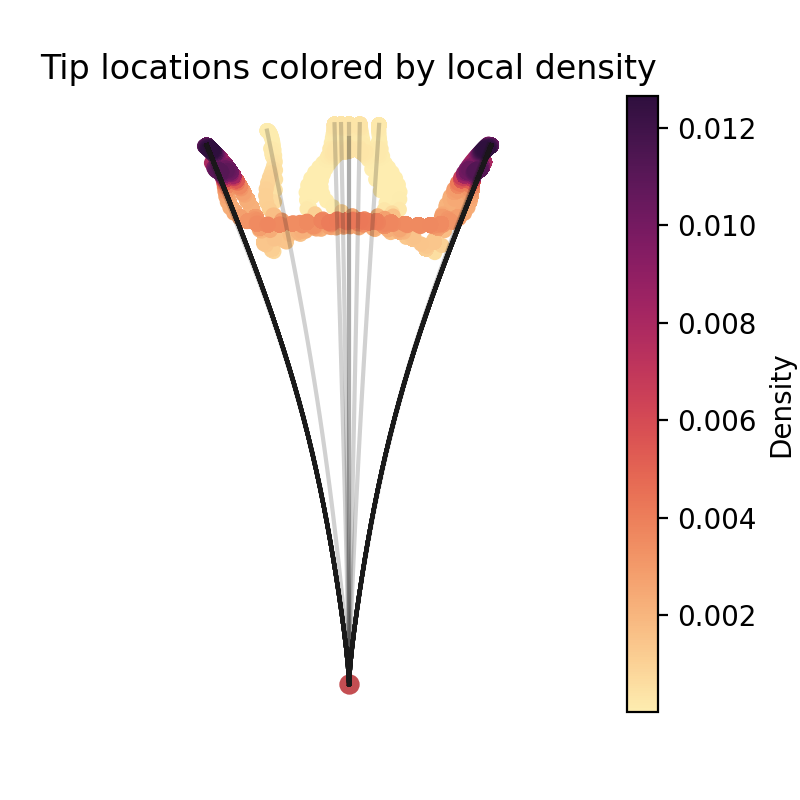

saving figure...


In [13]:
plt.style.use('default')

filament.plot_tip_scatter_density(save = True, num_cycles=100, save_folder=publication_figures)

## Publication plots: Unique sites visited time series

In [55]:
# Create an ensemble data frame containing the time-series of unique locations visited

# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep'
data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep_subset'

# Interpolate time-series data into a common time array
n_times = 1000

# Data frame containing the ensemble data
df_ensemble = pd.DataFrame({})

# Metadata to save
# metadata_list = ['spring constant', 'kappa_hat','potDipole strength']

variable = 'potDipole strength'

# Find all simulation data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files
for dirs, subdirs, files in os.walk(data_folder, topdown=False):
       
    
    root, subFolderName = os.path.split(dirs)
 
    if('SearchCoverage' in subFolderName):
        
        root, *rest = os.path.split(root) # root is the top-level folder 2 layers up to subfolder
   
        # Get the metadata for this condition
        df_metadata = pd.read_csv(os.path.join(root, 'metadata.csv'))
           
      
        
        
        count = 1
        for file in files:
            if('timeseries' in file):
                # Load the time-series data
                df_current = pd.read_csv(os.path.join(dirs,file))
                time = df_current['Time']
                data = df_current['Unique positions count']
                
                data_fun = interpolate.interp1d(time, data, kind = 'linear')
                
                time_vect_sampled = np.linspace(np.min(time), np.max(time), n_times)
                
                data_sampled = data_fun(time_vect_sampled)
                
                temp_dict = {var : [np.repeat(df_metadata[var], n_times)] for var in metadata_list}
                
                df_sampled = pd.DataFrame({'Time':time_vect_sampled, 'Initial condition': np.repeat(count, n_times),
                                           'Unique positions count': data_sampled, variable:np.repeat(df_metadata[variable], n_times), 'activity time scale':np.repeat(df_metadata[' activity time scale'], n_times)})
                
                
                df_ensemble = df_ensemble.append(df_sampled)
                count +=1 


In [56]:
df_ensemble

Time  Initial condition  Unique positions count  \
0        0.000000                  1                1.000000   
0      375.375375                  1               28.537538   
0      750.750751                  1               35.075075   
0     1126.126126                  1               55.612613   
0     1501.501502                  1               80.150150   
..            ...                ...                     ...   
0   373498.498498                  3              231.000000   
0   373873.873874                  3              231.000000   
0   374249.249249                  3              231.000000   
0   374624.624625                  3              231.000000   
0   375000.000000                  3              231.000000   

    potDipole strength  activity time scale  
0             4.730769                  750  
0             4.730769                  750  
0             4.730769                  750  
0             4.730769                  750  
0             4.730769                  750  
..                 ...                  ...  
0             1.589744                  750  
0             1.589744                  750  
0             1.589744                  750  
0             1.589744                  750  
0             1.589744                  750  

[18000 rows x 5 columns]

### Plot the time-series of unique locations sampled

In [43]:
# Subset of parameter values to plot
potDipole_strengths = [np.linspace(0.5, 3, 10), np.linspace(3, 5.5, 10)]  

potDipole_strengths

[array([0.5       , 0.77777778, 1.05555556, 1.33333333, 1.61111111,
        1.88888889, 2.16666667, 2.44444444, 2.72222222, 3.        ]),
 array([3.        , 3.27777778, 3.55555556, 3.83333333, 4.11111111,
        4.38888889, 4.66666667, 4.94444444, 5.22222222, 5.5       ])]

<IPython.core.display.Javascript object>


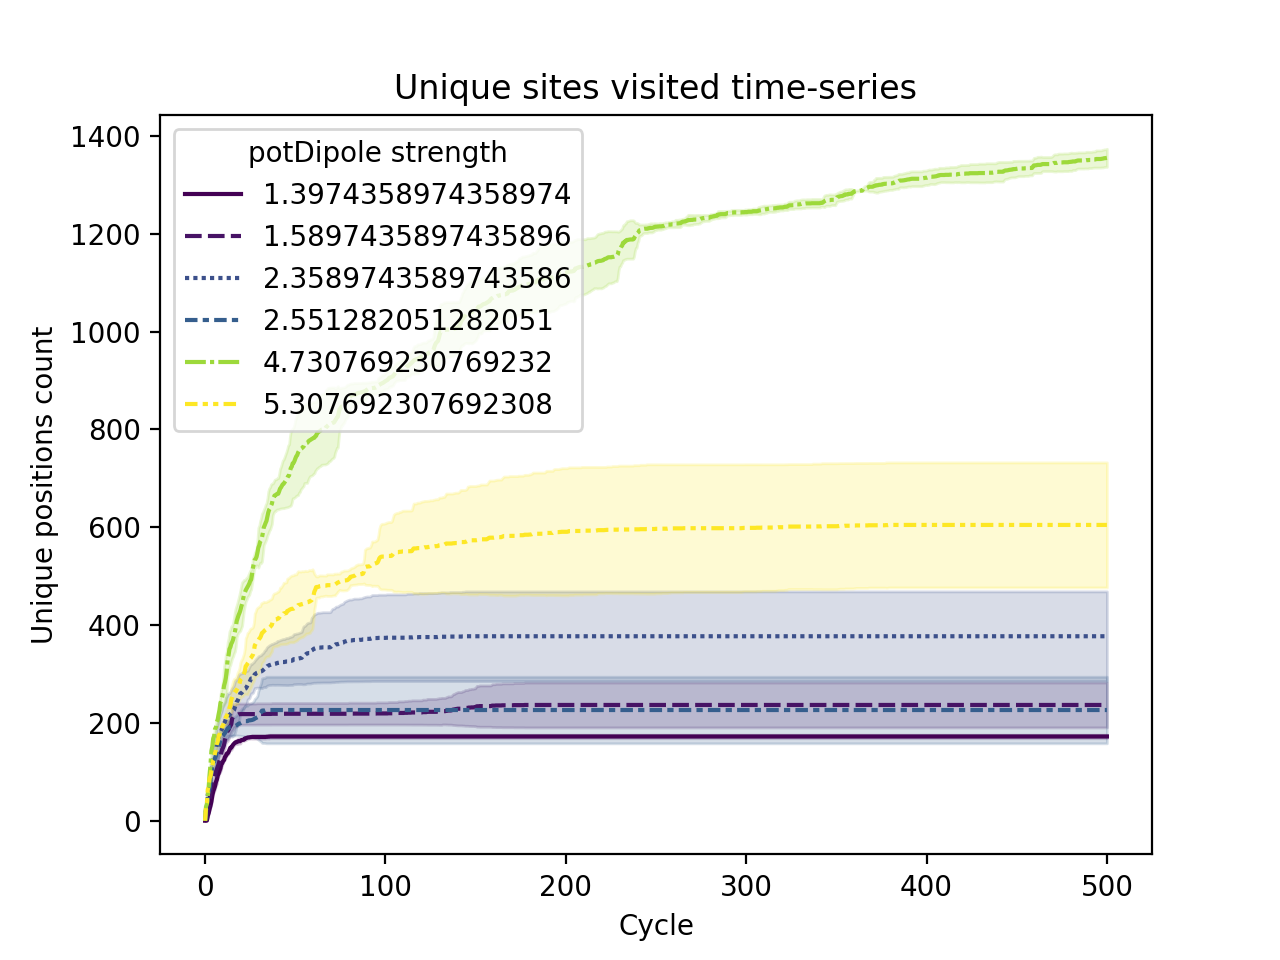

In [68]:
# Plot the timer-series of unique locations sampled

# plt.style.use('dark_background')
plt.style.use('default')

title = 'Unique sites visited time-series'
plt.figure()

sns.lineplot(data = df_ensemble, x = df_ensemble['Time']/df_ensemble['activity time scale'], 
             y = 'Unique positions count', hue = variable, style = variable, ci = 'sd', palette = 'viridis')

plt.title(title)
plt.xlabel('Cycle')
# plt.legend(loc=(1.04,0), borderaxespad = 0)
plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()

# plt.xscale('log')
# plt.yscale('log')
# plt.savefig(os.path.join(save_folder, title +'loglog' + '.png'), dpi = 300)
# plt.savefig(os.path.join(save_folder, title + 'loglog' + '.svg'), dpi = 300)

    
    

<IPython.core.display.Javascript object>


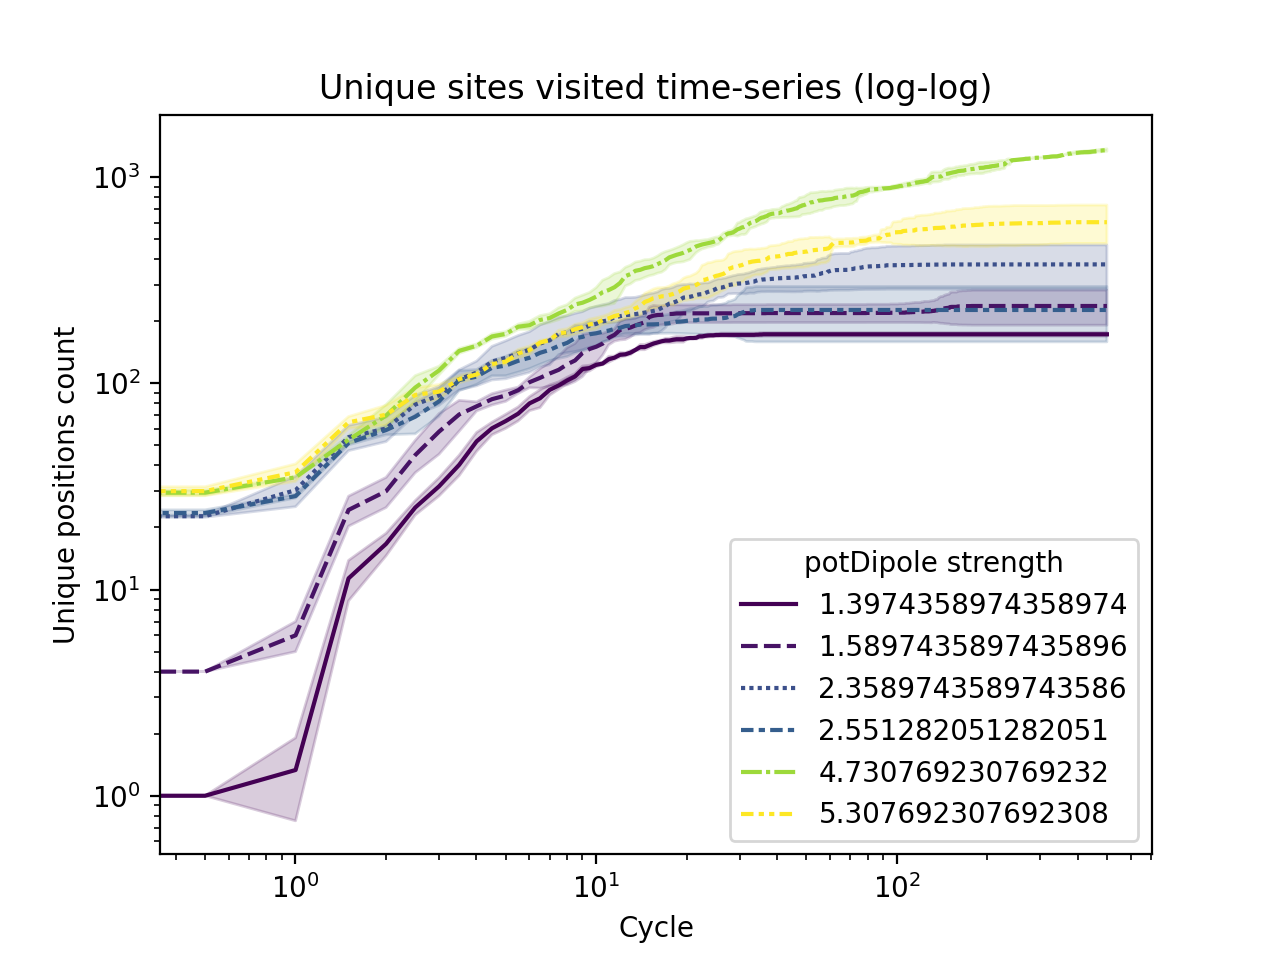

In [66]:
title = 'Unique sites visited time-series (log-log)'
plt.figure()

sns.lineplot(data = df_ensemble, x = df_ensemble['Time']/df_ensemble['activity time scale'], 
             y = 'Unique positions count', hue = variable, style = variable, ci = 'sd', palette = 'viridis')

plt.title(title)
plt.xlabel('Cycle')
# plt.legend(loc=(1.04,0), borderaxespad = 0)
# plt.savefig(os.path.join(save_folder, title + '.png'), dpi = 300)
# plt.savefig(os.path.join(save_folder, title + '.svg'), dpi = 300)
plt.xscale('log')
plt.yscale('log')
plt.show()

# Max unique locations sampled

In [28]:
# Plot of max unique locations sampled vs filament stiffness
df_unique_locs = pd.DataFrame({})
for key in tqdm(sorted(df_param_sweep.keys())):
    
    n_init_cond = max(df_param_sweep[key]['Initial condition'])
    
    for ii in range(n_init_cond):
        
        max_data = np.max(df_param_sweep[key].loc[df_param_sweep[key]['Initial condition']==ii+1, data_name])
        kappa = 0.25*key
        activity_number = (mu*radius**3*L**2*D0/kappa)

        df_unique_locs = df_unique_locs.append(pd.DataFrame({parameter:[key], 'activity number': activity_number, 'Initial condition':[ii+1], data_name: [max_data], 'activity time':activity_time}))
    

df_unique_locs.to_csv(os.path.join(save_folder,'Max unique locations'+ '_' + 'Np_{}'.format(Np) + '_' + 'b0_{}'.format(b0)+'_'+ 'activityTime_{}'.format(activity_time)+'.csv'))

100%|██████████| 12/12 [00:00<00:00, 474.56it/s]


In [31]:
df_unique_locs

spring constant  activity number  Initial condition  \
0             15.0      1092.266667                  1   
0             17.5       936.228571                  1   
0             20.0       819.200000                  1   
0             22.5       728.177778                  1   
0             25.0       655.360000                  1   
0             27.5       595.781818                  1   
0             30.0       546.133333                  1   
0             32.5       504.123077                  1   
0             35.0       468.114286                  1   
0             37.5       436.906667                  1   
0             40.0       409.600000                  1   
0             45.0       364.088889                  1   

   Unique positions count  activity time  
0                   672.0            750  
0                  1029.0            750  
0                   765.0            750  
0                   650.0            750  
0                   688.0            750  
0                   654.0            750  
0                   615.0            750  
0                  1088.0            750  
0                   964.0            750  
0                   822.0            750  
0                   778.0            750  
0                   597.0            750

<IPython.core.display.Javascript object>


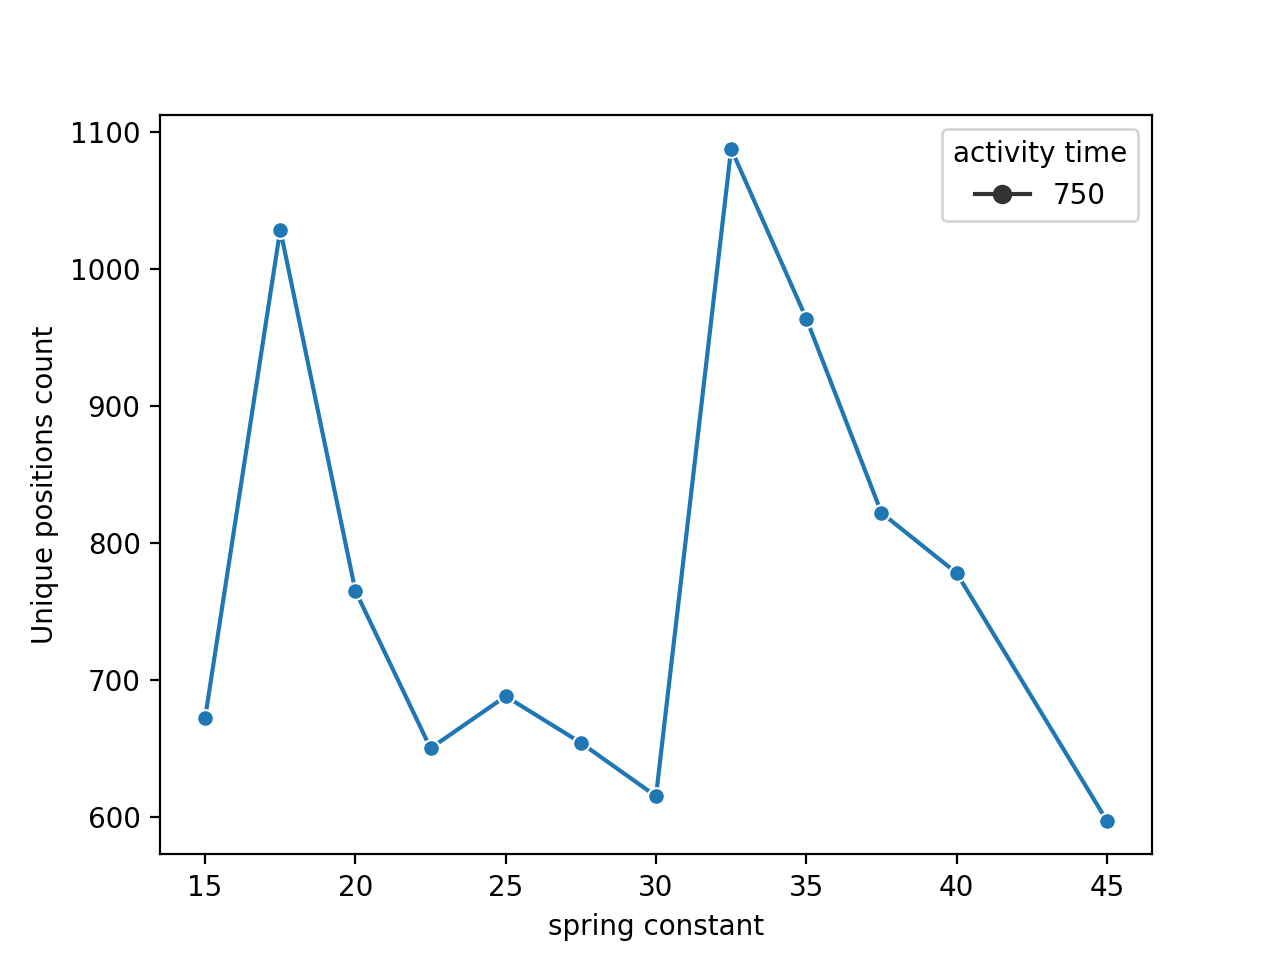

In [32]:
# plt.style.use('dark_background')
plt.style.use('default')


title = 'Max unique locations vs activity number'+ '_' + 'Np_{}'.format(Np) + '_' + 'b0_{}'.format(b0)+'_'+ 'activityTime_{}'.format(activity_time) 
plt.figure()
ax = sns.lineplot(data=df_unique_locs, x= 'spring constant', y= data_name, style='activity time', err_style="bars", ci="sd", markers=True)

# ax.set_xscale('log')
# plt.savefig(os.path.join(save_folder, title + '.png'), dpi = 300)
# plt.savefig(os.path.join(save_folder, title + '.svg'), dpi = 300)
plt.show()


In [117]:
# Plot unique locations vs stiffness for all activity time
folder = '/home/deepak/Dropbox/LacryModeling/ModellingResults/Plots/CombinedAnalysis/MaxUniqueLocations_combined_data'

files = os.listdir(folder)

df_combined = pd.DataFrame({})

for file in files:
    df = pd.read_csv(os.path.join(folder, file))
    df_combined = df_combined.append(df)

<IPython.core.display.Javascript object>


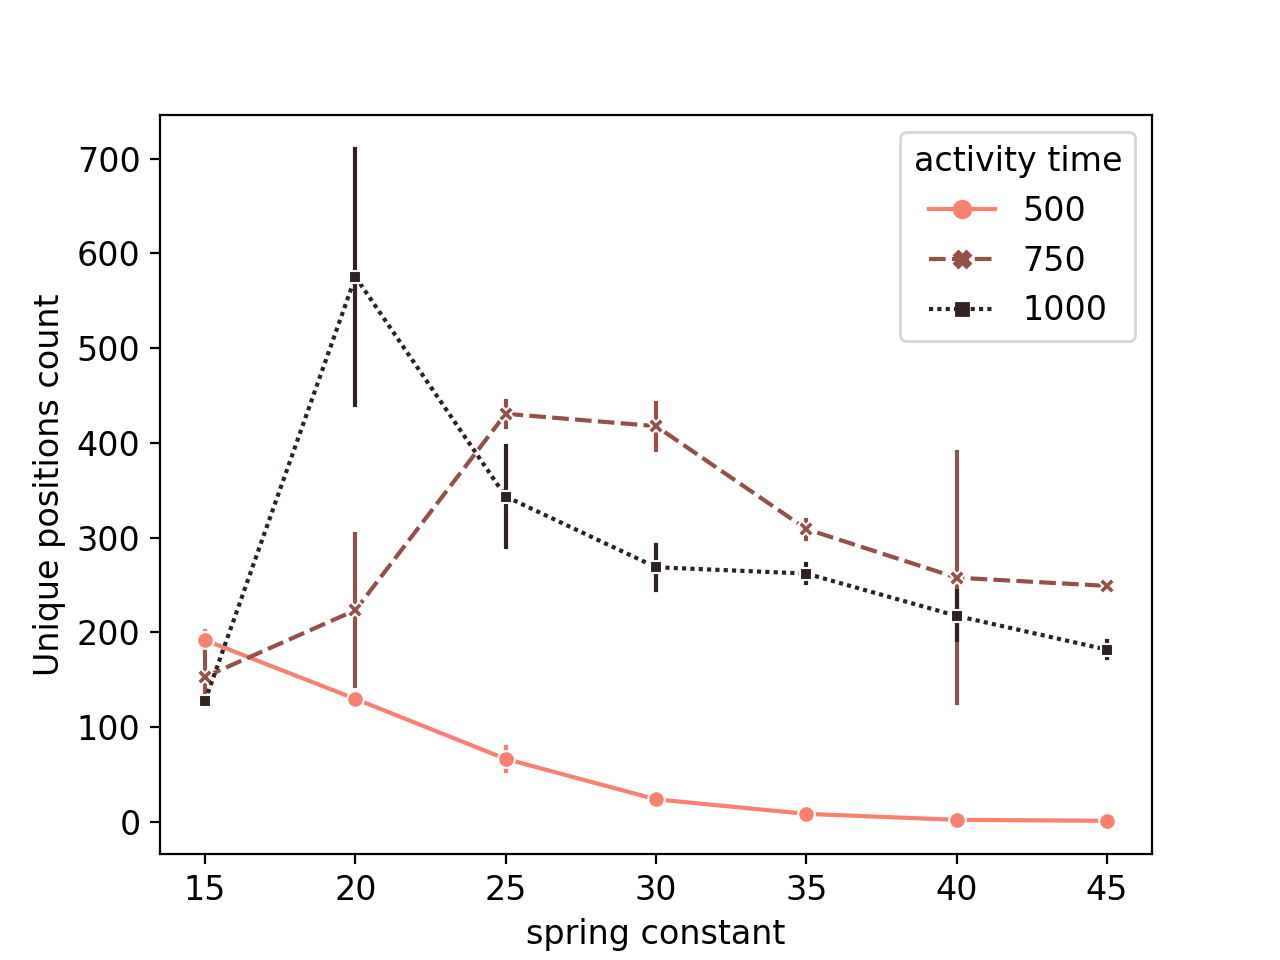

In [125]:
# Plot the unique locations vs stiffness for all activity time
title = 'Max unique locations vs filament stiffness_combined'+ '_' + 'Np_{}'.format(Np) + '_' + 'b0_{}'.format(b0)
plt.figure()
sns.lineplot(data=df_combined, x= parameter, y= data_name, style='activity time', hue = 'activity time', err_style="bars", ci="sd", markers=True, palette = "dark:salmon_r")
plt.savefig(os.path.join(save_folder, title + '.png'), dpi = 300)
plt.savefig(os.path.join(save_folder, title + '.svg'), dpi = 300)
plt.show()

# Plot search metrics and other dynamical measures as a function of one or more filament parameters

In [49]:
# Load all the analysis data and collate into a single data frame
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/BendingStiffnessSweeps/b0_2_1_FullSweep_Final'
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FinerResolution_BendingStiffness'
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-06-24'
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FinerResolution_BendingStiffness'

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/BendingStiffnessSweeps/b0_2_1_FullSweep_Final', '/home/deepak/ActiveFilamentsSearch_backup_3/FinerResolution_BendingStiffness' ]

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-08-18']
# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-08-15', '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-08-16']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/BendingStiffnessSweeps/b0_2_1_FullSweep_Final/activity_time_750', '/home/deepak/ActiveFilamentsSearch_backup_3/FinerResolution_BendingStiffness' ]
# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep', '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-08-28']
data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep']

# Find all analysis data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files

for data_folder in data_folders:
    for dirs, subdirs, files in os.walk(data_folder, topdown=False):

        root, subFolderName = os.path.split(dirs)

        for fileNames in files:
            if(fileNames.endswith('csv') and fileNames[0] != '.' and 'analysis' in fileNames):
                files_list.append(os.path.join(dirs,fileNames))

print(files_list)
print('No:of files: {}'.format(len(files_list)))

['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-28/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.2564102564102564_activityTime_750_simType_point/Analysis/SimResults_01_analysis.csv', '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-28/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.2564102564102564_activityTime_750_simType_point/Analysis/SimResults_00_analysis.csv', '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-28/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.2564102564102564_activityTime_750_simType_point/Analysis/SimResults_02_analysis.csv', '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-28/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_5.371794871794871_activityTime_750_simType_point/Analysis/SimResults_01_analysis.csv', '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-28/SimRe

In [50]:
# Collect all data into a single data frame
df = pd.DataFrame({})

for file in files_list:
    
    df = df.append(pd.read_csv(file))
    

    
df['periodic dynamics'][df['periodic dynamics']==1.0] = True
df['periodic dynamics'][df['periodic dynamics']==0.0] = False
df['period'][pd.isna(df['period'])] = 'aperiodic'
df['period'][df['simulation completed']== False] = 'Escape'
df

/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

Unnamed: 0  N particles  radius  bond length  spring constant  kappa_hat  \
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
..         ...          ...     ...          ...              ...        ...   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   

    force strength  stresslet strength  potDipole strength simulation type  \
0                0                   0            3.256410           point   
0                0                   0            3.256410           point   
0                0                   0            3.256410           point   
0                0                   0            5.371795           point   
0                0                   0            5.371795           point   
..             ...                 ...                 ...             ...   
0                0                   0            0.564103           point   
0                0                   0            0.564103           point   
0                0                   0            1.076923           point   
0                0                   0            1.076923           point   
0                0                   0            1.076923           point   

   boundary condition 0 boundary condition 1   activity time scale  viscosity  \
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
..                  ...                  ...                   ...        ...   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   

       period  simulation completed  periodic dynamics  max unique locations  \
0   aperiodic                  True              False                1245.0   
0   aperiodic                  True              False                1171.0   
0   aperiodic                  True              False                1225.0   
0   aperiodic                  True              False                 985.0   
0   aperiodic                  True              False                 984.0   
..        ...                   ...                ...                   ...   
0           1                  True               True                   1.0   
0           1                  True               True                   1.0   
0   aperiodic                  True              False                  21.0   
0   aperiodic                  True              False                  23.0   
0   aperiodic                  True              False                  20.0   

    activity cycles completed  
0                         500  
0                         500  
0                         500  
0                         500  
0           

<IPython.core.display.Javascript object>


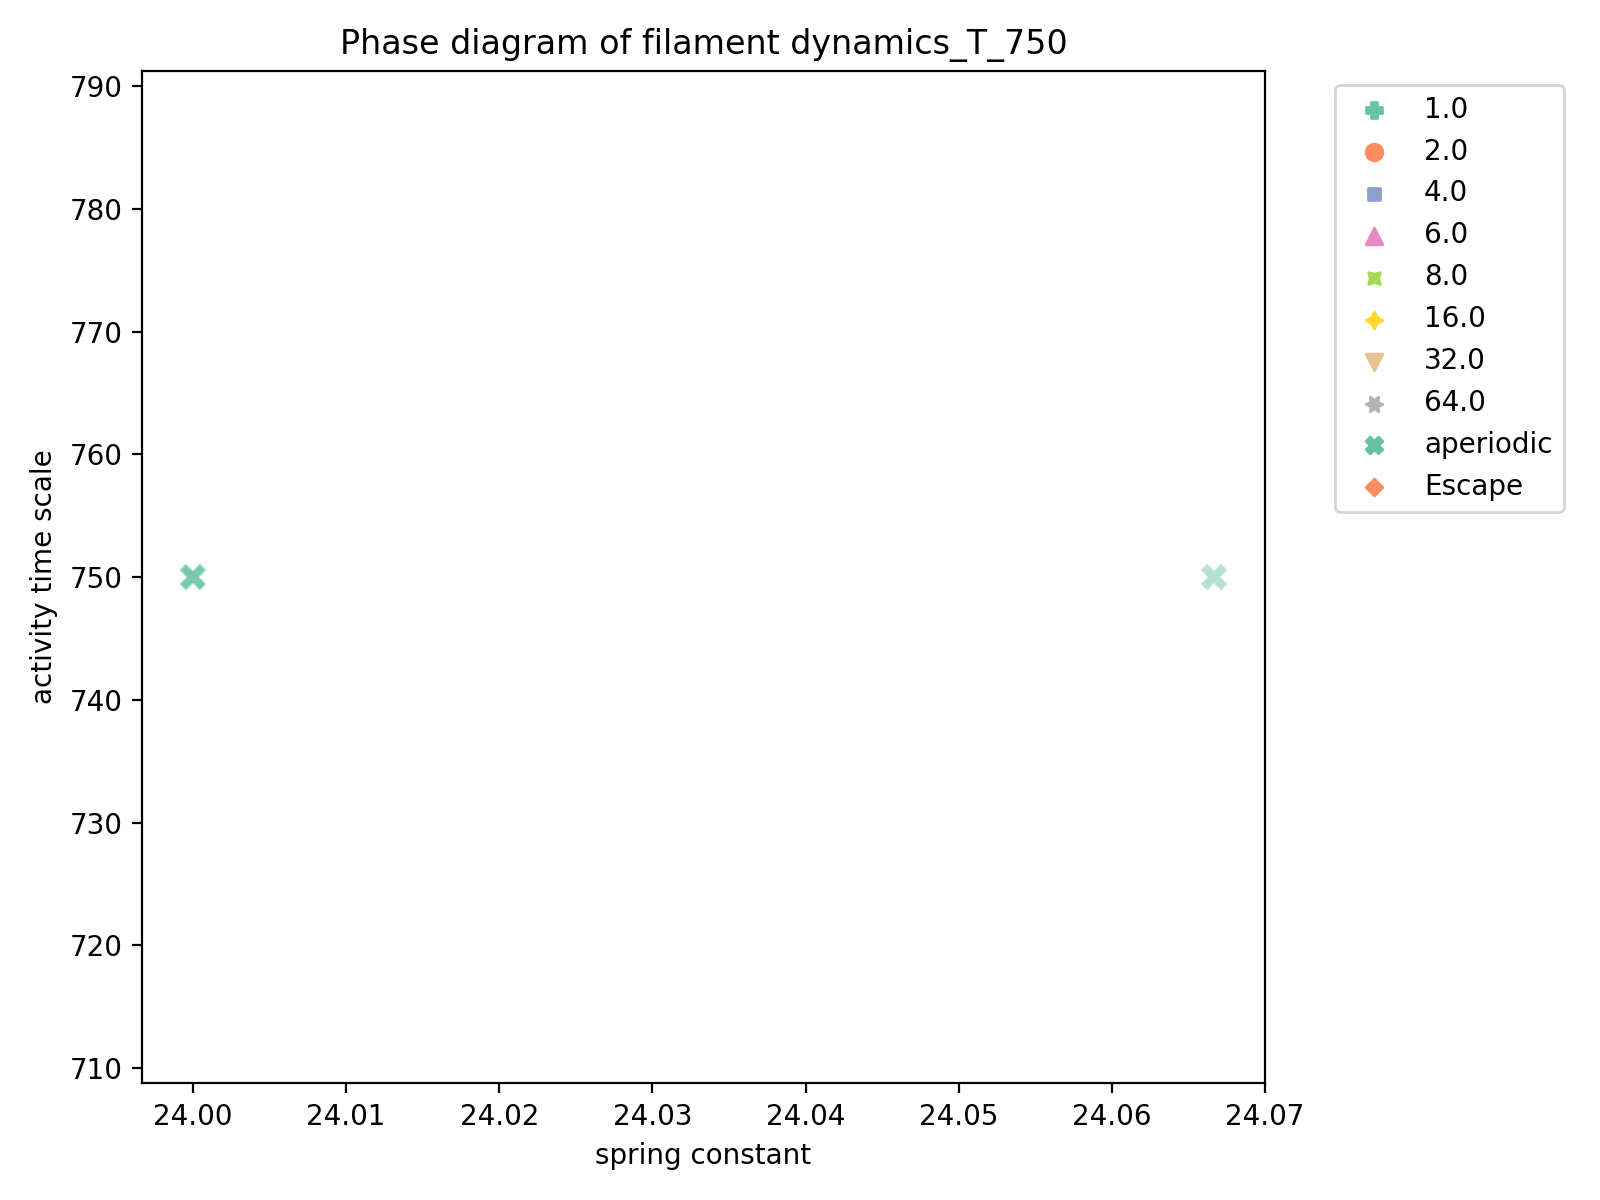

In [67]:
# Plot the max unique locations sampled vs filament stiffness and Activity Time-scale
save_folder = '/home/deepak/Dropbox/LacryModeling/AnalysisResults/CombinedAnalysis'

# Specify Markers used 
# markers = {1.0: "o", 2.0: "X", 3.0: "+",4.0: "d", 6.0: "p", 8.0: "v", 16.0:"d",'aperiodic':"*",'Escape':'<'}
# colors = {"1.0": "o", "2.0": "x", "3.0": "+","4.0": "d", "6.0": "p", "8.0": "p", "16.0":"^","aperiodic":"*",'Escape':'.'}

title = 'Phase diagram of filament dynamics'
fig, ax = plt.subplots(figsize=(8,6))
# sns.scatterplot(x="spring constant", y=" activity time scale", hue="max unique locations", size="max unique locations",
#             sizes=(40, 400), alpha=1, palette="flare", data=df, style = "period", ax = ax,style_order = [1.0, 2.0, 4.0, 6.0, 16.0, 'aperiodic'])
sns.scatterplot(x="spring constant", y="activity time scale", hue="period",
            sizes=(400, 400), alpha=0.5, palette="Set2", data=df, style = "period", ax = ax,hue_order = [1.0, 2.0, 4.0, 6.0, 8.0, 16.0, 32.0, 64.0, 'aperiodic', 'Escape'], s= 100)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title(title)
plt.tight_layout() 
# plt.savefig(os.path.join(save_folder, title+'.png'), dpi = 300)
# plt.savefig(os.path.join(save_folder, title+'.svg'), dpi = 300)

<IPython.core.display.Javascript object>


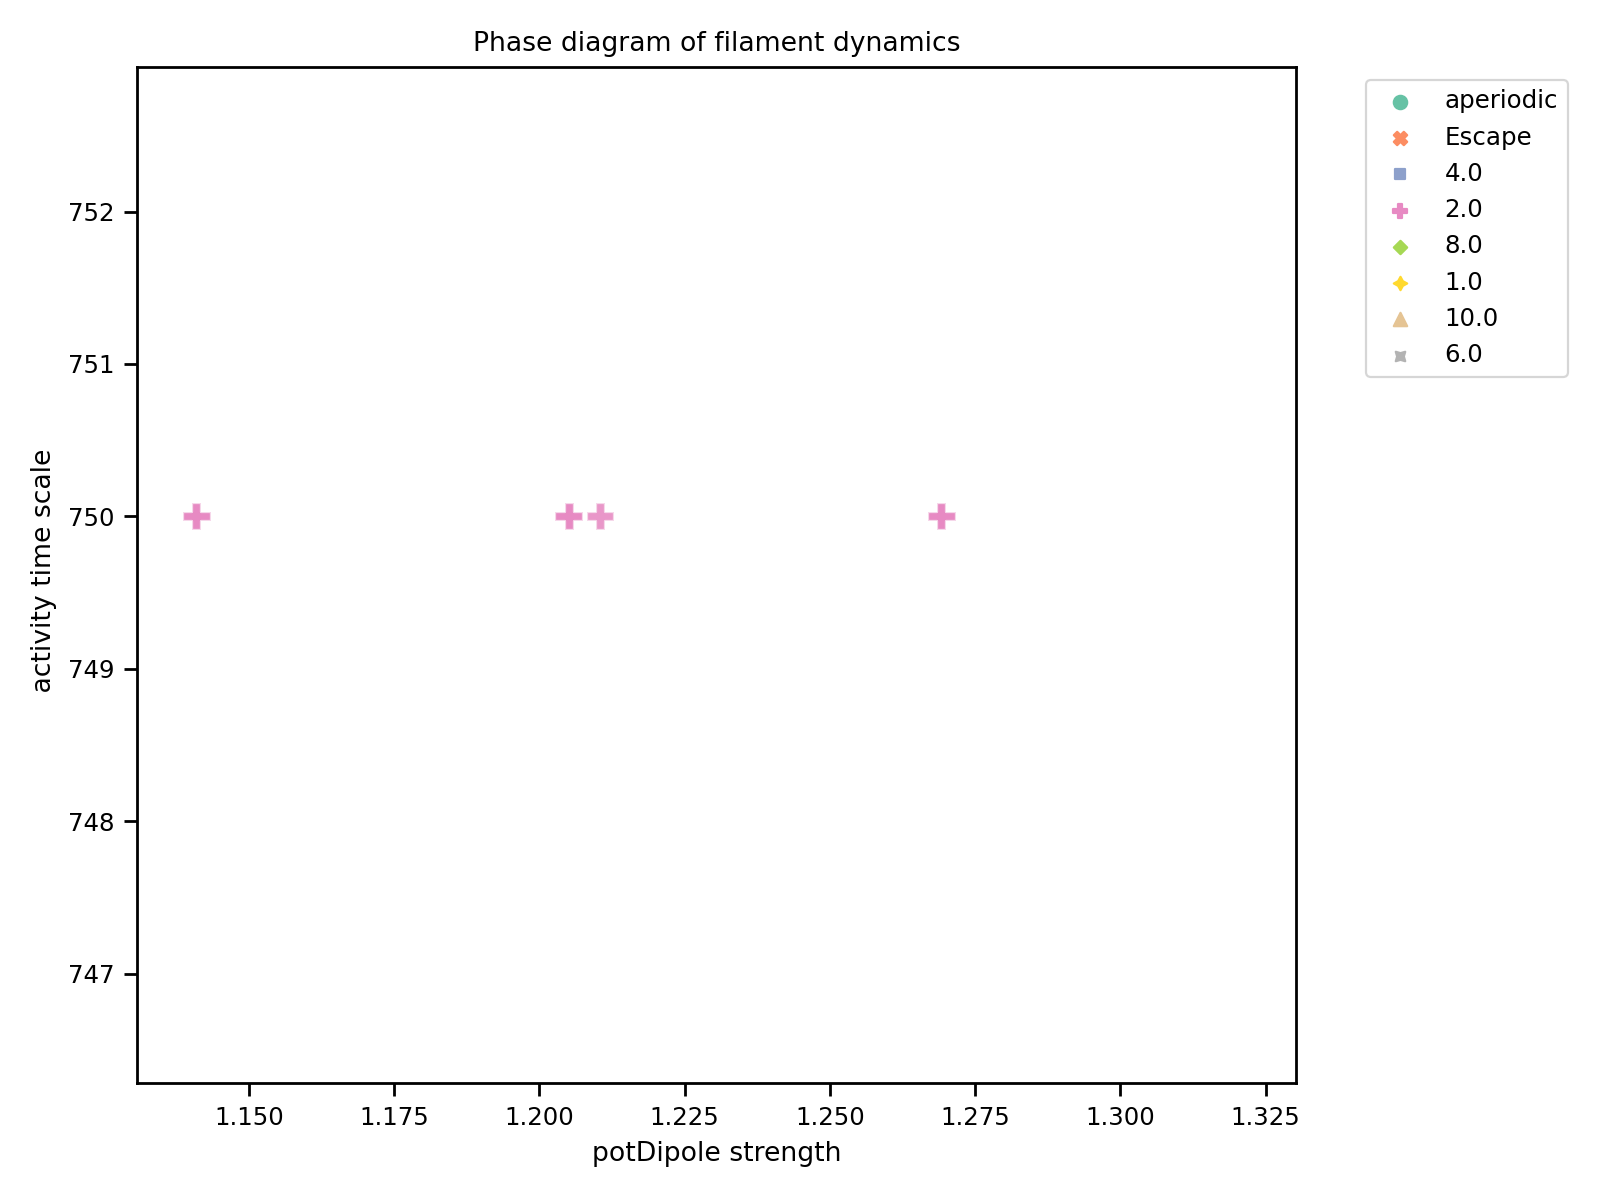

In [67]:
title = 'Phase diagram of filament dynamics'
fig, ax = plt.subplots(figsize=(8,6))
# sns.scatterplot(x="spring constant", y=" activity time scale", hue="max unique locations", size="max unique locations",
#             sizes=(40, 400), alpha=1, palette="flare", data=df, style = "period", ax = ax,style_order = [1.0, 2.0, 4.0, 6.0, 16.0, 'aperiodic'])
sns.scatterplot(x="potDipole strength", y=" activity time scale", hue="period",
            sizes=(400, 400), alpha=0.5, palette="Set2", data=df, style = "period", ax = ax, s= 100)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title(title)
plt.tight_layout() 

<IPython.core.display.Javascript object>


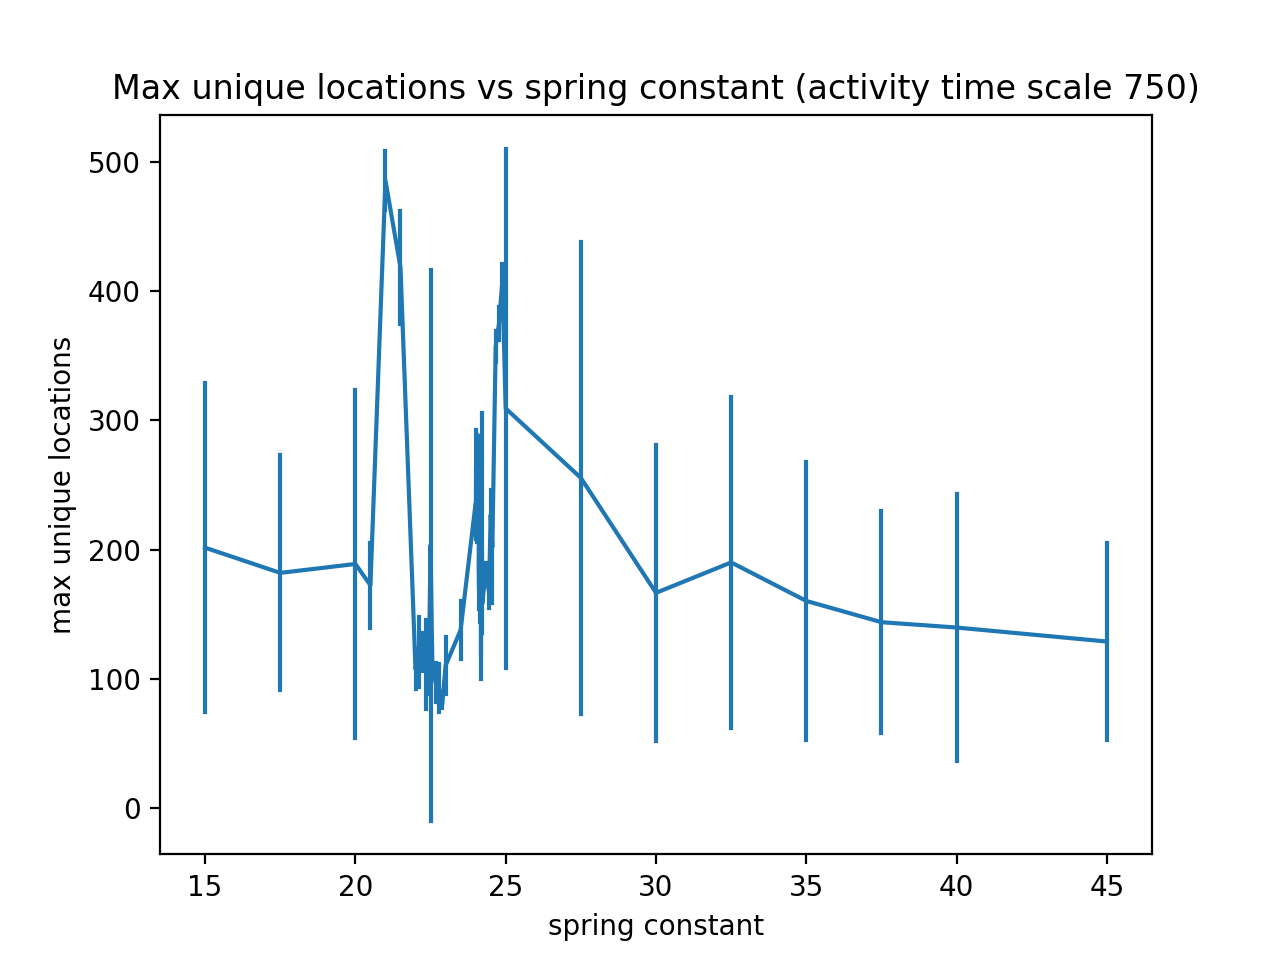

In [66]:
plt.style.use('default')
activity_time_scale = df[' activity time scale'][:][0]
title = 'Max unique locations vs spring constant (activity time scale {})'.format(750)
plt.figure()
ax = sns.lineplot(data=df, x= 'spring constant', y= 'max unique locations', err_style="bars", ci="sd", markers=True)

# ax.set_xscale('log')
# plt.savefig(os.path.join(save_folder, title + '.png'), dpi = 300)
# plt.savefig(os.path.join(save_folder, title + '.svg'), dpi = 300)
plt.title(title)
plt.show()

<IPython.core.display.Javascript object>


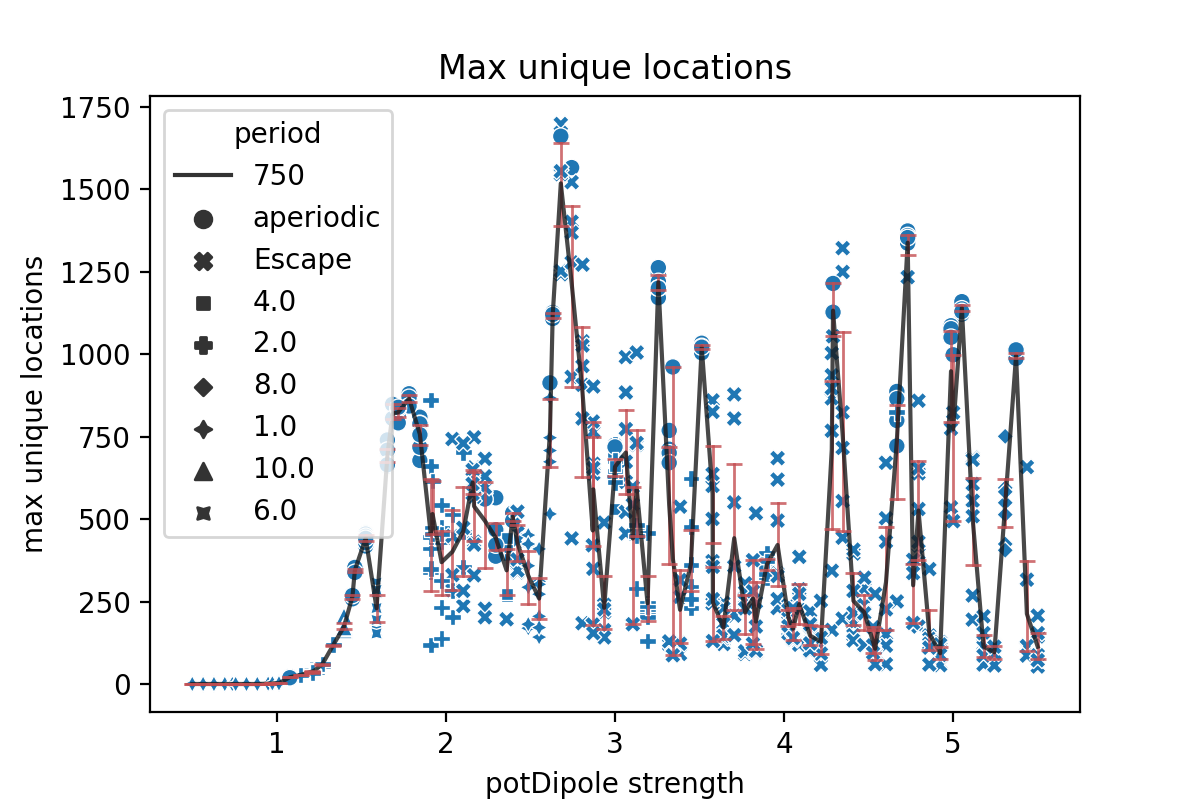

In [51]:
# Create a folder for storing Publication figures

publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'


# Set the values for the publication figure parameters
rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 14})
sns.set(font_scale = 1)


# Plot Max unique locations sampled vs Activity strength

plt.style.use('default')
activity_time_scale = df[' activity time scale'][:][0]
title = 'Max unique locations'
plt.figure(figsize=(6, 4))
# ax = sns.lineplot(data=df, x= 'potDipole strength', y= 'max unique locations', ci=None, markers=False, dashes = False, color = 'k')

ax1 = sns.lineplot(data=df, x= 'potDipole strength', y= 'max unique locations', style=" activity time scale", markers=None, ci=95, err_style = 'bars', err_kws= {'capsize':3, 'elinewidth':1, 'ecolor':'r'}, markerfacecolor='r', markeredgecolor='w', color = 'k', alpha =0.8)

ax2 = sns.scatterplot(data=df, x= 'potDipole strength', y= 'max unique locations', style="period")


# ax.set_xscale('log')
# plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
# plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.title(title)
plt.show()

<IPython.core.display.Javascript object>


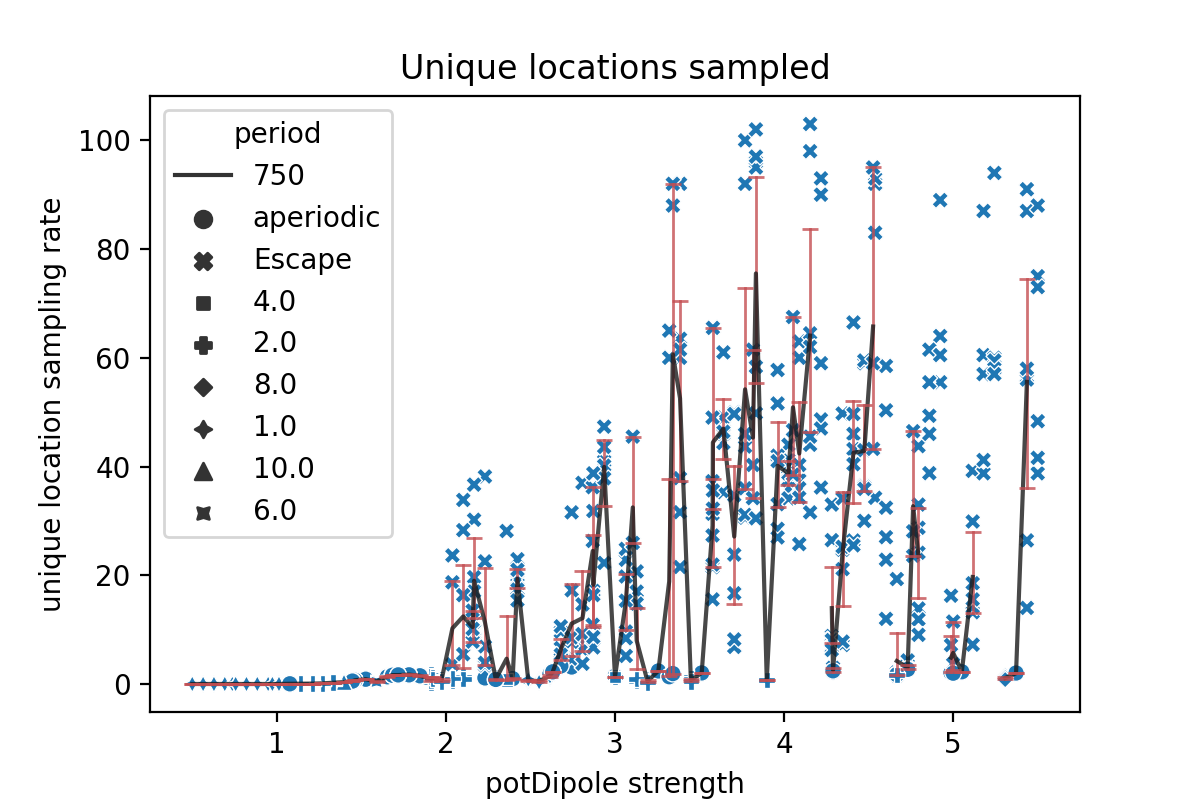

/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/seaborn/utils.py:55: RuntimeWarning: invalid value encountered in double_scalars
  ehigh = high - h
/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:3411: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]


In [52]:
# Plot No:of unique locations sampled/simulation cycles 

plt.style.use('default')
activity_time_scale = df[' activity time scale'][:][0]

df['unique location sampling rate'] = df['max unique locations']/df['activity cycles completed']
title = 'Unique locations sampled'
plt.figure(figsize=(6, 4))
# ax = sns.lineplot(data=df, x= 'potDipole strength', y= 'max unique locations', ci=None, markers=False, dashes = False, color = 'k')

ax1 = sns.lineplot(data=df, x= 'potDipole strength', y= 'unique location sampling rate', style=" activity time scale", markers=None, ci=95, err_style = 'bars', err_kws= {'capsize':3, 'elinewidth':1, 'ecolor':'r'}, markerfacecolor='r', markeredgecolor='w', color = 'k', alpha =0.8)

ax2 = sns.scatterplot(data=df, x= 'potDipole strength', y= 'unique location sampling rate', style="period")


# ax.set_xscale('log')
# plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
# plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.title(title)
plt.show()

In [53]:
# Take subset of data for which simulation was completed
df_subset = df.loc[df['simulation completed']==True]

df_subset

Unnamed: 0  N particles  radius  bond length  spring constant  kappa_hat  \
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
..         ...          ...     ...          ...              ...        ...   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   
0            0           32       1          2.1               25       6.25   

    force strength  stresslet strength  potDipole strength simulation type  \
0                0                   0            3.256410           point   
0                0                   0            3.256410           point   
0                0                   0            3.256410           point   
0                0                   0            5.371795           point   
0                0                   0            5.371795           point   
..             ...                 ...                 ...             ...   
0                0                   0            0.564103           point   
0                0                   0            0.564103           point   
0                0                   0            1.076923           point   
0                0                   0            1.076923           point   
0                0                   0            1.076923           point   

   boundary condition 0 boundary condition 1   activity time scale  viscosity  \
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
..                  ...                  ...                   ...        ...   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   
0               clamped                 free                   750   0.166667   

       period  simulation completed  periodic dynamics  max unique locations  \
0   aperiodic                  True              False                1245.0   
0   aperiodic                  True              False                1171.0   
0   aperiodic                  True              False                1225.0   
0   aperiodic                  True              False                 985.0   
0   aperiodic                  True              False                 984.0   
..        ...                   ...                ...                   ...   
0           1                  True               True                   1.0   
0           1                  True               True                   1.0   
0   aperiodic                  True              False                  21.0   
0   aperiodic                  True              False                  23.0   
0   aperiodic                  True              False                  20.0   

    activity cycles completed  unique location sampling rate  
0                         500                          2.490  
0                         500                 

/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<IPython.core.display.Javascript object>


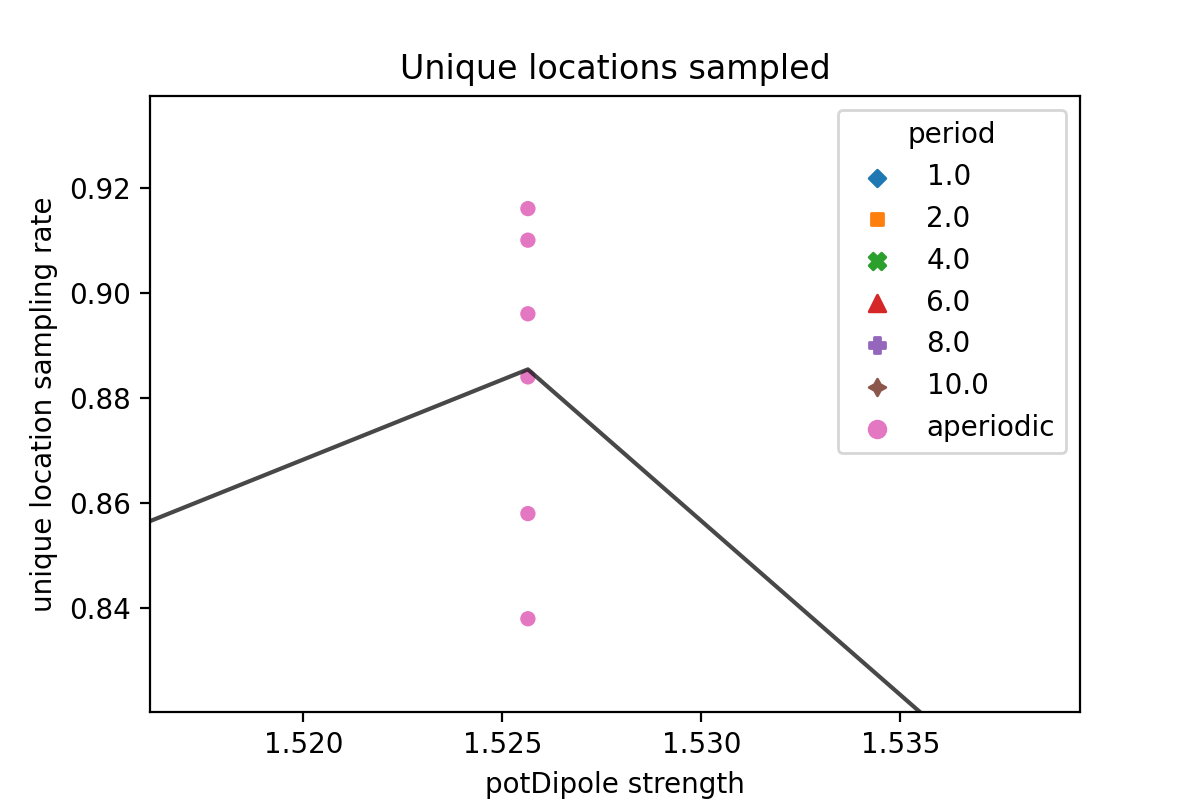

In [54]:
# Plot unique locations sampling rate only for simulations where there is no escape

plt.style.use('default')

df_subset['unique location sampling rate'] = df_subset['max unique locations']/df_subset['activity cycles completed']


title = 'Unique locations sampled'
plt.figure(figsize=(6, 4))
# ax = sns.lineplot(data=df, x= 'potDipole strength', y= 'max unique locations', ci=None, markers=False, dashes = False, color = 'k')

# ax1 = sns.lineplot(data=df_subset, x= 'potDipole strength', y= 'unique location sampling rate', style=" activity time scale", markers=None, ci=95, err_style = 'bar', err_kws= {'capsize':3, 'elinewidth':1, 'ecolor':'r'}, markerfacecolor='r', markeredgecolor='w', color = 'k', alpha =0.8, legend = False)
ax1 = sns.lineplot(data=df_subset, x= 'potDipole strength', y= 'unique location sampling rate', style=" activity time scale", markers=None, ci=None, err_style = 'band', markerfacecolor='r', markeredgecolor='w', color = 'k', alpha =0.8, legend = False)

ax2 = sns.scatterplot(data=df_subset, x= 'potDipole strength', y= 'unique location sampling rate', style="period", hue = 'period', hue_order = [1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 'aperiodic'])


# ax.set_xscale('log')
plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.title(title)
plt.show()

In [58]:
print(x_label_values)

[0.5        0.56410256 0.62820513 0.69230769 0.73684211 0.75641026
 0.82051282 0.88461538 0.94871795 0.97368421 1.01282051 1.07692308
 1.14102564 1.20512821 1.21052632 1.26923077 1.33333333 1.3974359
 1.44736842 1.46153846 1.52564103 1.58974359 1.65384615 1.68421053
 1.71794872 1.78205128 1.84615385 1.91025641 1.92105263 1.97435897
 2.03846154 2.1025641  2.15789474 2.16666667 2.23076923 2.29487179
 2.35897436 2.39473684 2.42307692 2.48717949 2.55128205 2.61538462
 2.63157895 2.67948718 2.74358974 2.80769231 2.86842105 2.87179487
 2.93589744 3.         3.06410256 3.10526316 3.12820513 3.19230769
 3.25641026 3.32051282 3.34210526 3.38461538 3.44871795 3.51282051
 3.57692308 3.57894737 3.64102564 3.70512821 3.76923077 3.81578947
 3.83333333 3.8974359  3.96153846 4.02564103 4.05263158 4.08974359
 4.15384615 4.21794872 4.28205128 4.28947368 4.34615385 4.41025641
 4.47435897 4.52631579 4.53846154 4.6025641  4.66666667 4.73076923
 4.76315789 4.79487179 4.85897436 4.92307692 4.98717949 5.
 5.0

# Plot tip locations visted by filament (at constant phase) vs different simulation parameters

In [46]:
# Activity strength
# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep', '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-08-28']

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-10-18']
data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep']

# Spring constant
# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/BendingStiffnessSweeps/b0_2_1_FullSweep_Final/activity_time_750', '/home/deepak/ActiveFilamentsSearch_backup_3/FinerResolution_BendingStiffness' ]

# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-08-15', '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-08-16']
# Find all analysis data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files

for data_folder in data_folders:
    for dirs, subdirs, files in os.walk(data_folder, topdown=False):

        root, subFolderName = os.path.split(dirs)

        for fileNames in files:
            if(fileNames.endswith('hdf5') and fileNames[0] != '.' and 'analysis' in fileNames):
                files_list.append(os.path.join(dirs,fileNames))

print(files_list)
print('No:of files: {}'.format(len(files_list)))

['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-28/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.2564102564102564_activityTime_750_simType_point/Analysis/SimResults_02_analysis.hdf5', '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-28/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.2564102564102564_activityTime_750_simType_point/Analysis/SimResults_00_analysis.hdf5', '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-28/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.2564102564102564_activityTime_750_simType_point/Analysis/SimResults_01_analysis.hdf5', '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-28/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_5.371794871794871_activityTime_750_simType_point/Analysis/SimResults_02_analysis.hdf5', '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-28/S

In [55]:
# Build a data frame with all the data and the parameter of interest
# Collect all data into a single data frame
df = pd.DataFrame({})
# parameter = 'spring constant'
parameter = 'potDipole strength'

for file in files_list:
    
    with h5py.File(file, "r") as f:
        if('analysis data' in f.keys()): # Load the simulation data (newer method)
                    
            dset = f['analysis data']
            
            if(dset.attrs['Sim complete']==True):
                parameter_value = dset.attrs[parameter]
                
                period = dset.attrs['period']
                if(np.isnan(period)):
                    period = 'aperiodic'
                tip_angles = dset['Tip angles'][:]

                df_file = pd.DataFrame({parameter:np.repeat(parameter_value, len(tip_angles),axis=0), 'Tip angles':tip_angles,'period':np.repeat(period, len(tip_angles),axis=0)})
                
              
                df = df.append(df_file, ignore_index=True)

In [15]:
# # pd.set_option('display.max_rows', None)
df

potDipole strength  Tip angles     period
0                3.256410    0.526189  aperiodic
1                3.256410    0.454257  aperiodic
2                3.256410    0.112279  aperiodic
3                3.256410    0.300087  aperiodic
4                3.256410   -0.533572  aperiodic
...                   ...         ...        ...
84331            1.076923    0.026490  aperiodic
84332            1.076923   -0.014088  aperiodic
84333            1.076923   -0.050127  aperiodic
84334            1.076923    0.056034  aperiodic
84335            1.076923   -0.027924  aperiodic

[84336 rows x 3 columns]

<IPython.core.display.Javascript object>


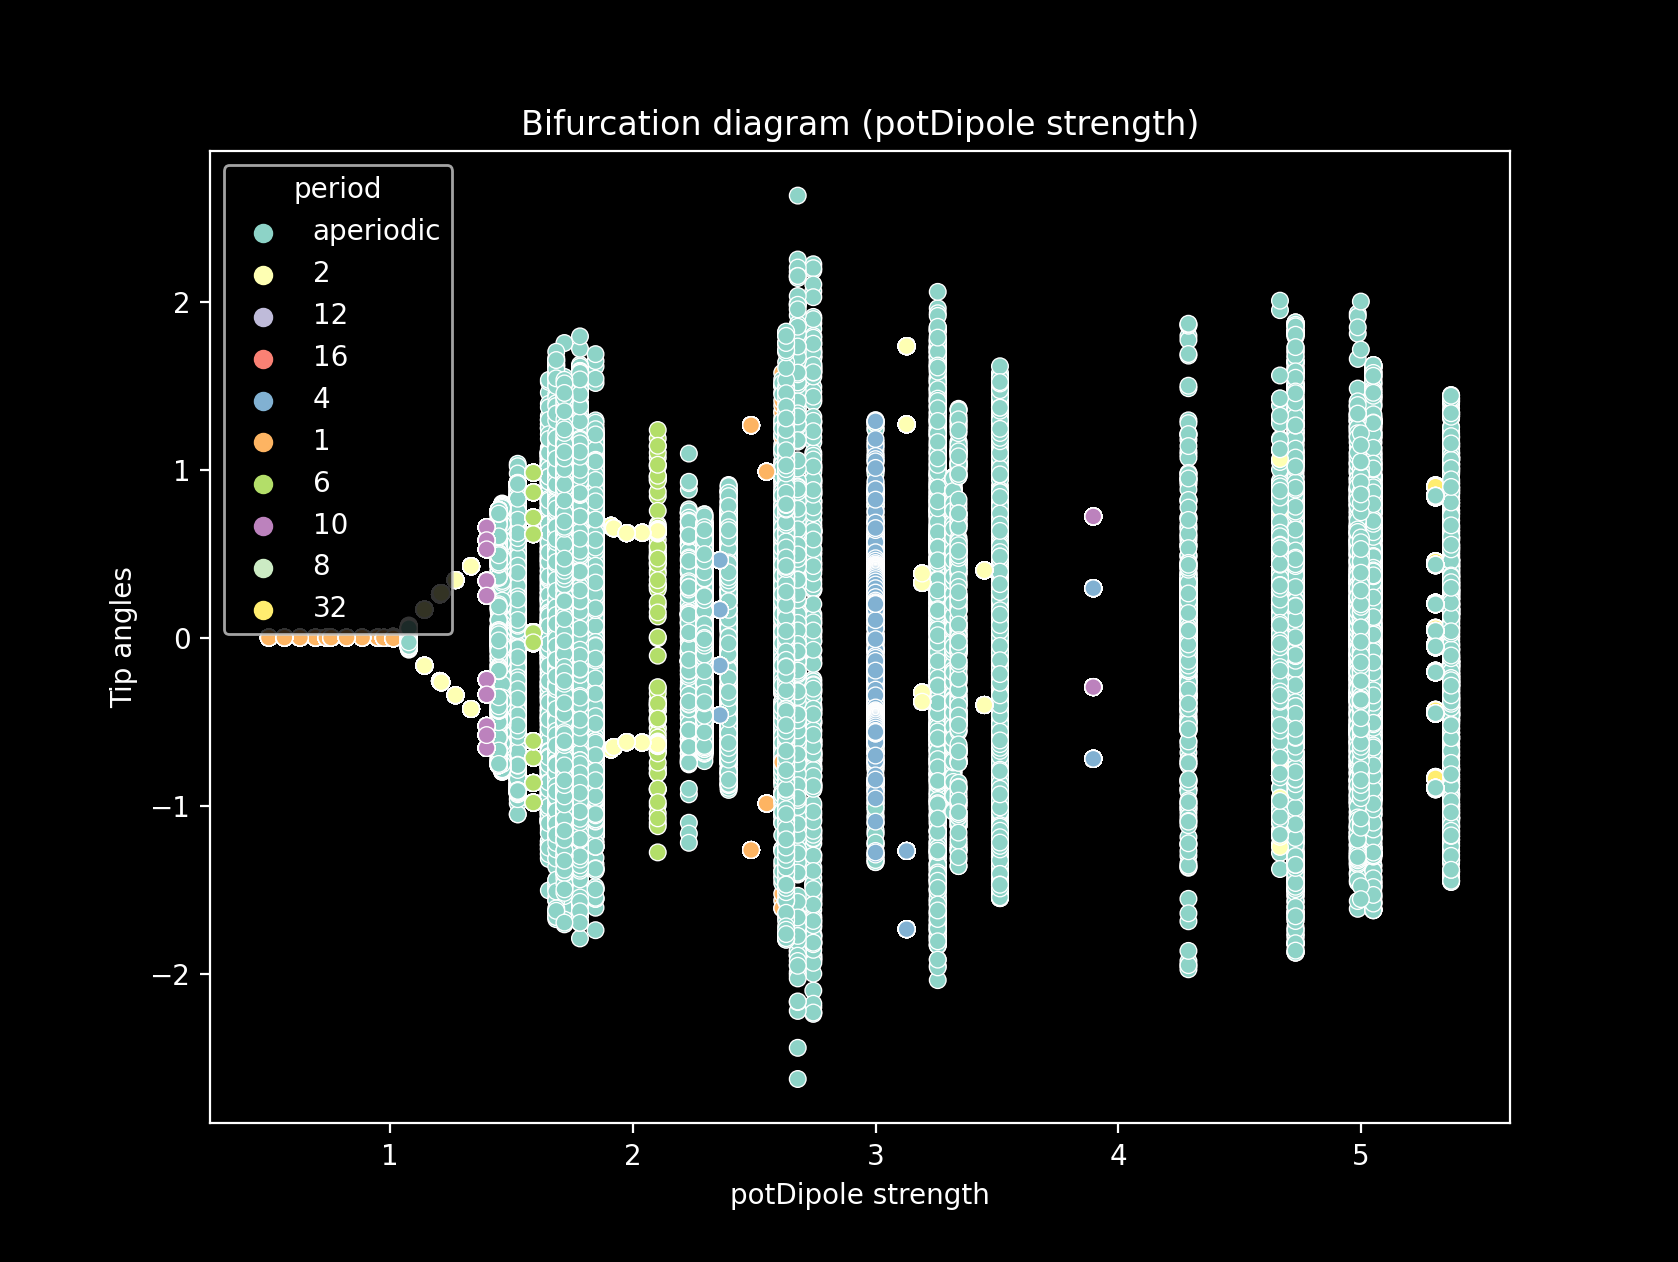

In [16]:
# Plot the locations visited by the filament vs different parameters
plt.style.use('dark_background')
title = 'Bifurcation diagram ({})'.format(parameter)
plt.figure()
sns.scatterplot(x = parameter, y = 'Tip angles', hue = 'period' , data = df, estimator = None, legend= True)
plt.title(title)
# plt.savefig(os.path.join(save_folder, title + '.png'), dpi = 300)
# plt.savefig(os.path.join(save_folder, title + '.svg'), dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


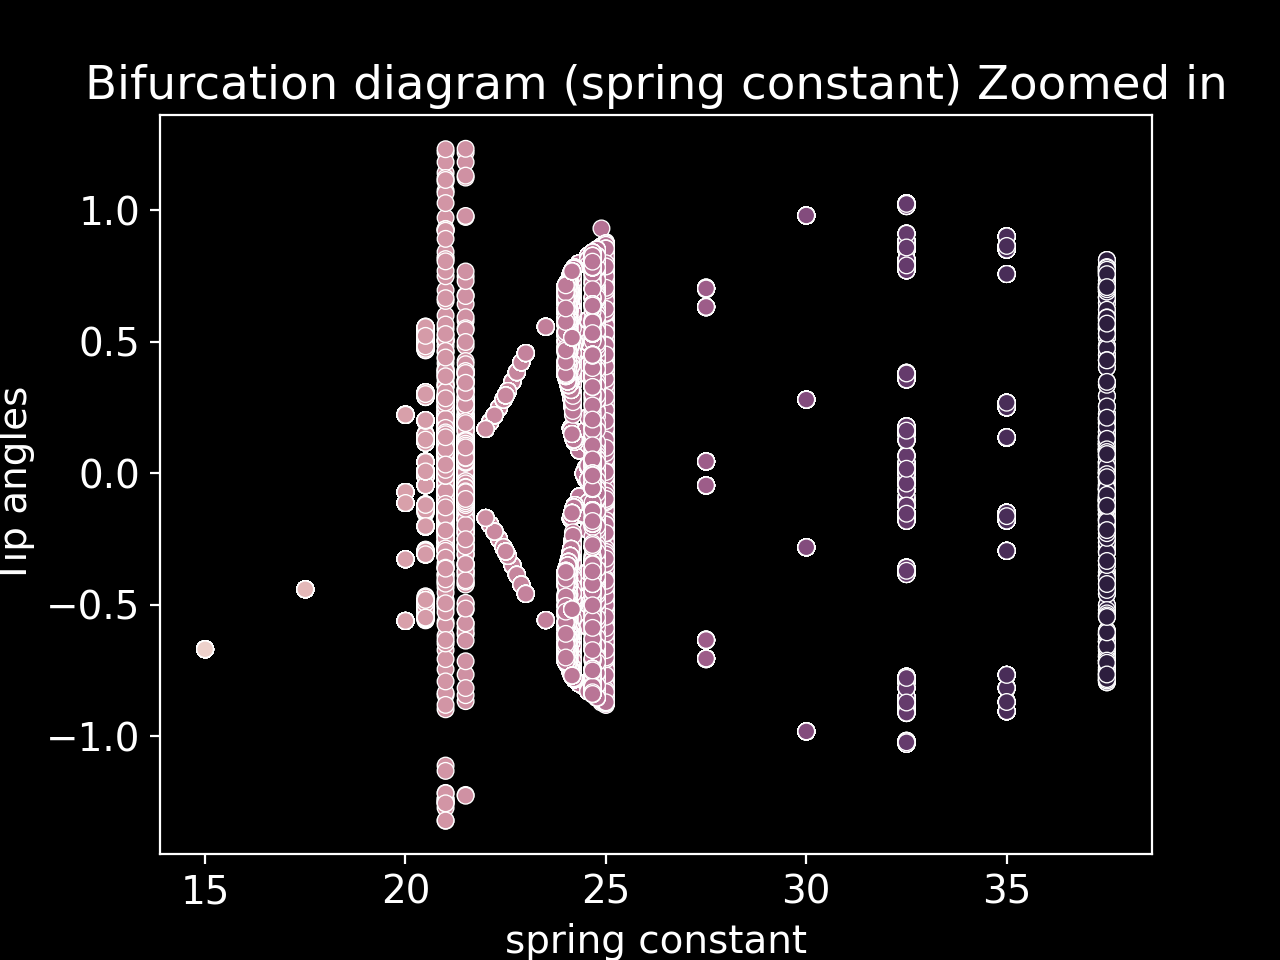

In [47]:
plt.style.use('dark_background')
title = 'Bifurcation diagram ({}) Zoomed in'.format(parameter)
plt.figure()
sns.scatterplot(x = parameter, y = 'Tip angles', hue = parameter, data = df[df[parameter]<40], estimator = None, legend= False)
plt.title(title)
plt.savefig(os.path.join(save_folder, title + '.png'), dpi = 300)
plt.savefig(os.path.join(save_folder, title + '.svg'), dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


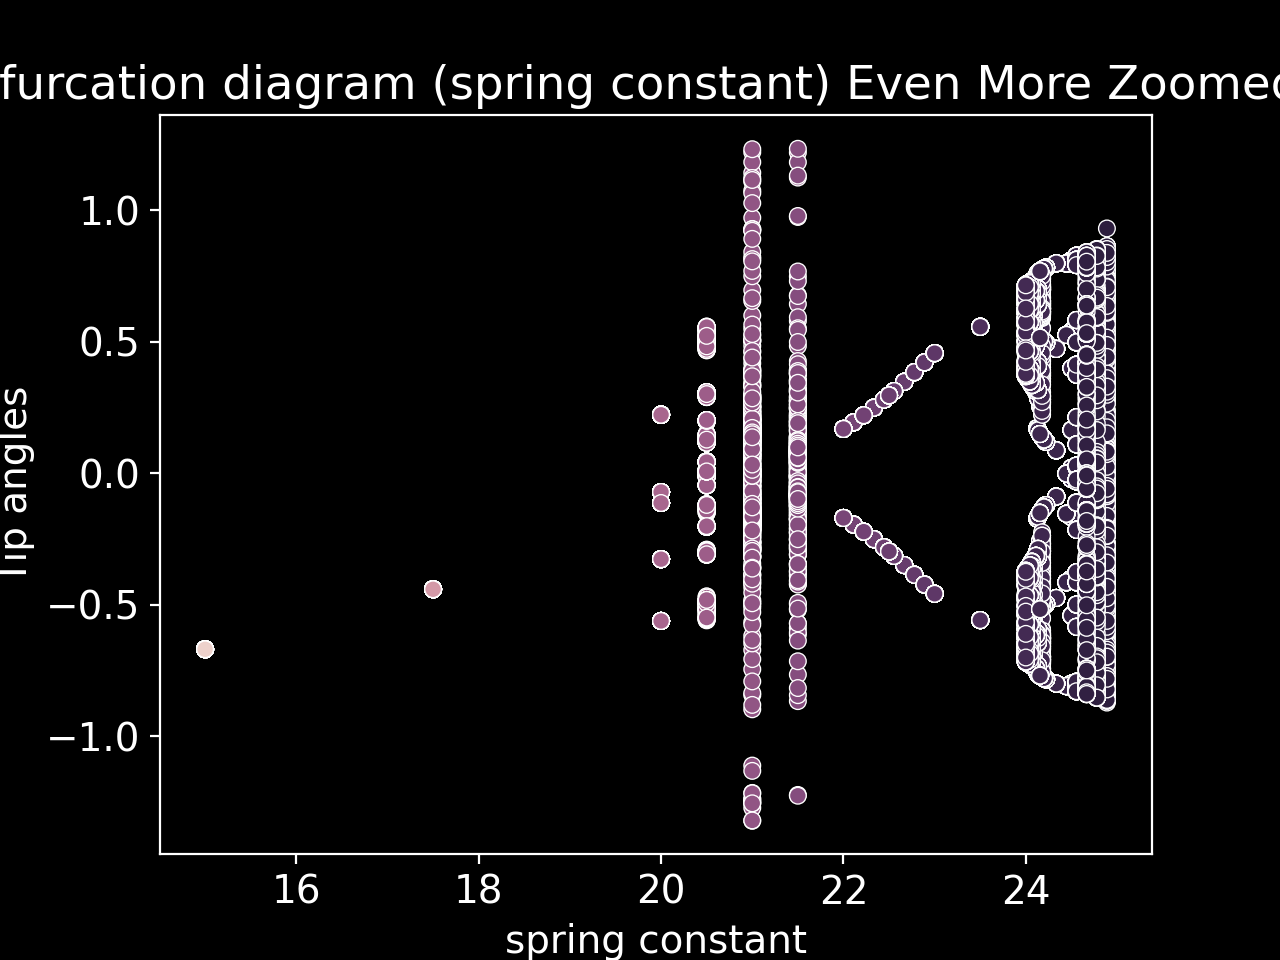

In [52]:
plt.style.use('dark_background')
title = 'Bifurcation diagram ({}) Even More Zoomed in'.format(parameter)
plt.figure()
sns.scatterplot(x = parameter, y = 'Tip angles', hue = parameter, data = df[df[parameter]<25], estimator = None, legend= False)
plt.title(title)
plt.savefig(os.path.join(save_folder, title + '.png'), dpi = 300)
plt.savefig(os.path.join(save_folder, title + '.svg'), dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


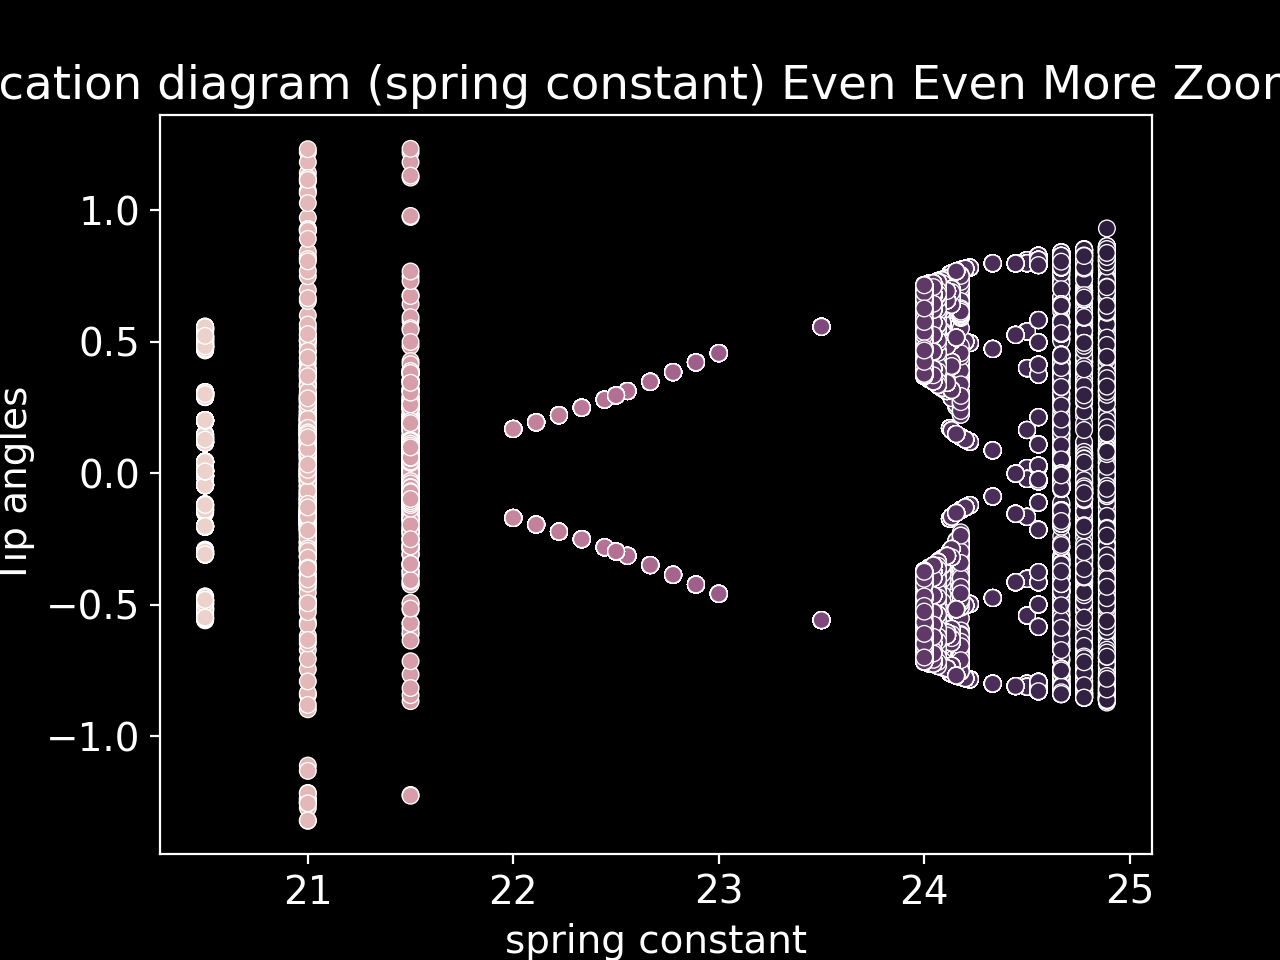

In [54]:
plt.style.use('dark_background')
title = 'Bifurcation diagram ({}) Even Even More Zoomed in'.format(parameter)
plt.figure()
sns.scatterplot(x = parameter, y = 'Tip angles', hue = parameter, data = df[(df[parameter]>20) & (df[parameter]<25)], estimator = None, legend= False)
plt.title(title)
plt.savefig(os.path.join(save_folder, title + '.png'), dpi = 300)
plt.savefig(os.path.join(save_folder, title + '.svg'), dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


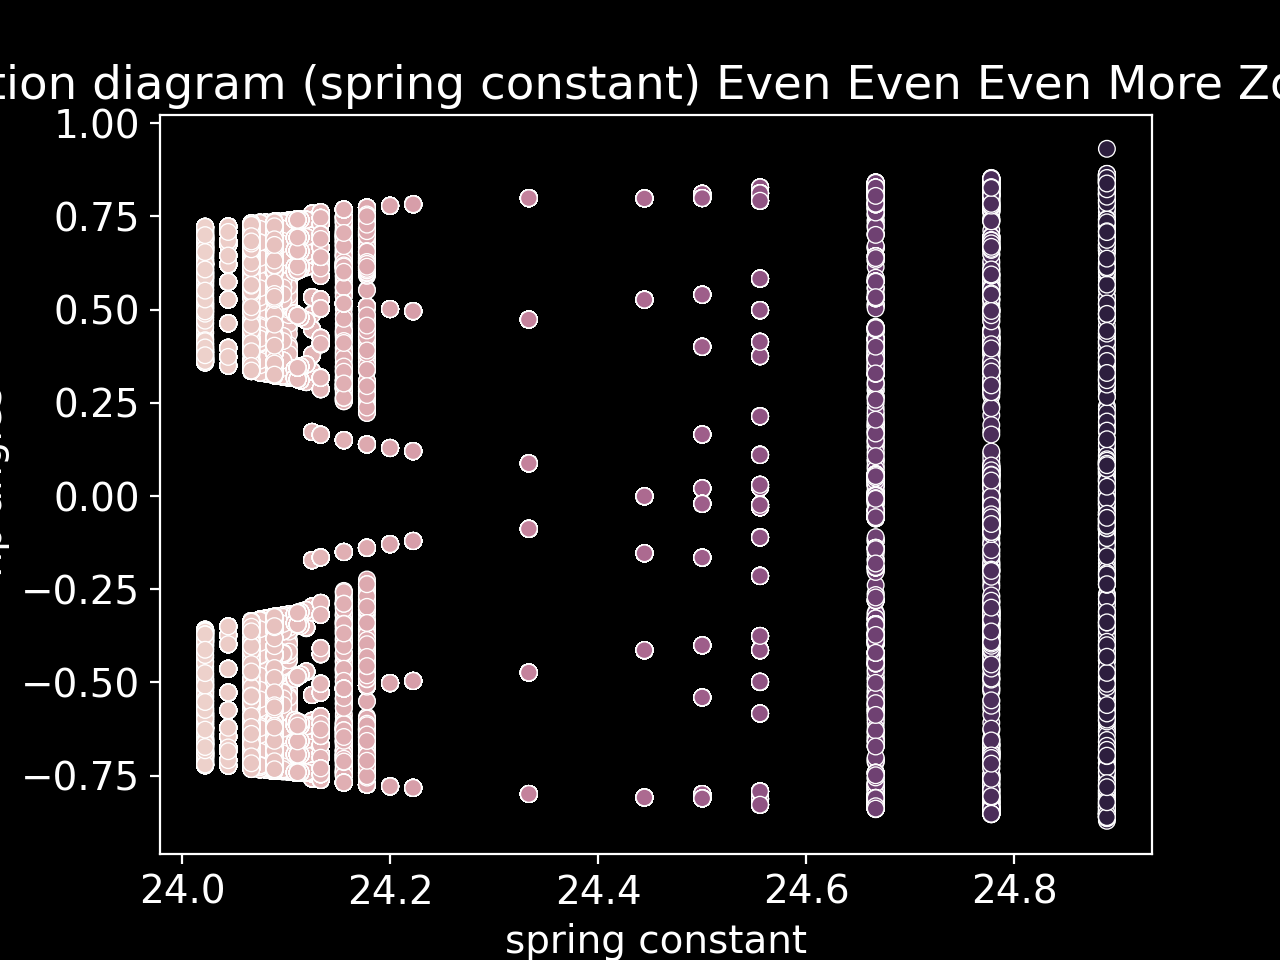

In [55]:
plt.style.use('dark_background')
title = 'Bifurcation diagram ({}) Even Even Even More Zoomed in'.format(parameter)
plt.figure()
sns.scatterplot(x = parameter, y = 'Tip angles', hue = parameter, data = df[(df[parameter]>24) & (df[parameter]<25)], estimator = None, legend= False)
plt.title(title)
plt.savefig(os.path.join(save_folder, title + '.png'), dpi = 300)
plt.savefig(os.path.join(save_folder, title + '.svg'), dpi = 300)
plt.show()

## Publication plots: Bifurcation diagrams

<IPython.core.display.Javascript object>


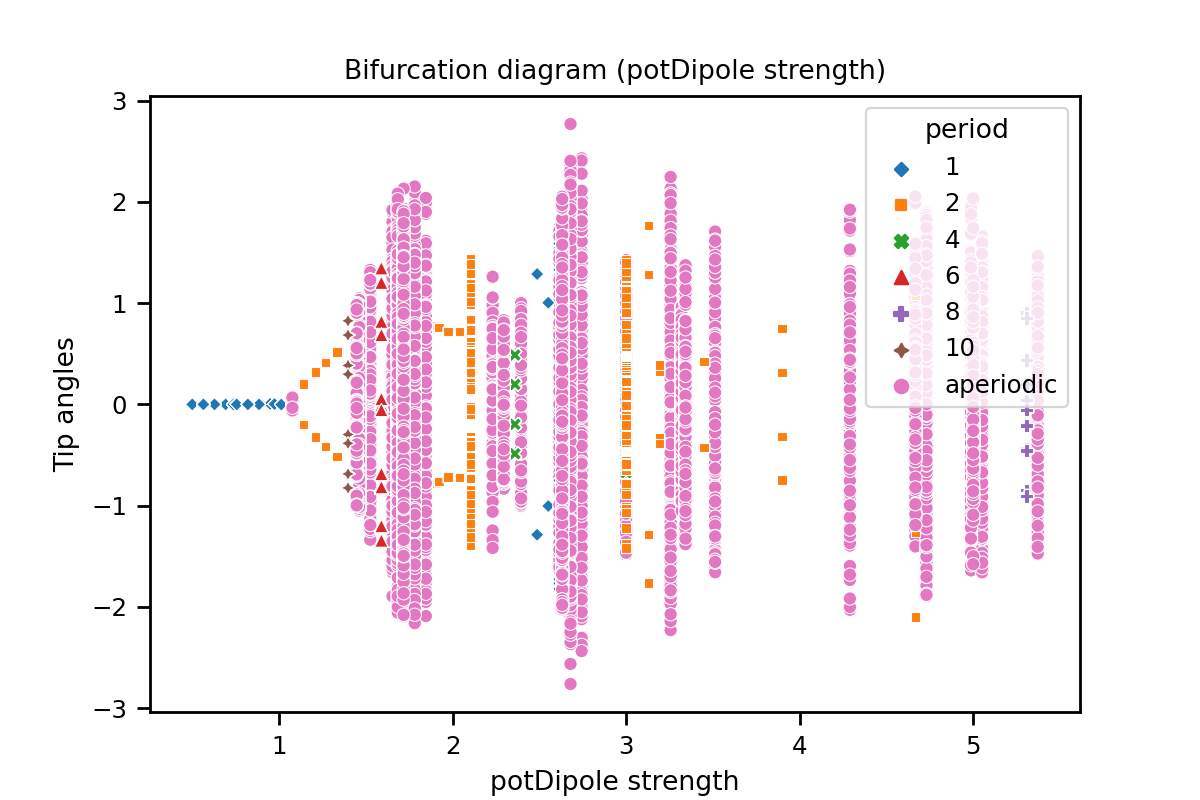

In [63]:

# Create a plot of Angular locations (at constant phase) vs parameter of interest (for Publication)
plt.style.use('default')

sns.set_context("paper")
title = 'Bifurcation diagram ({})'.format(parameter)
plt.figure(figsize=(6,4))
sns.scatterplot(x = parameter, y = 'Tip angles', hue = 'period', 
                style = 'period', data = df, estimator = None, hue_order = [1, 2, 4, 6, 8, 10, 'aperiodic'])
plt.title(title)
plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()